In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.patches import Polygon
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models


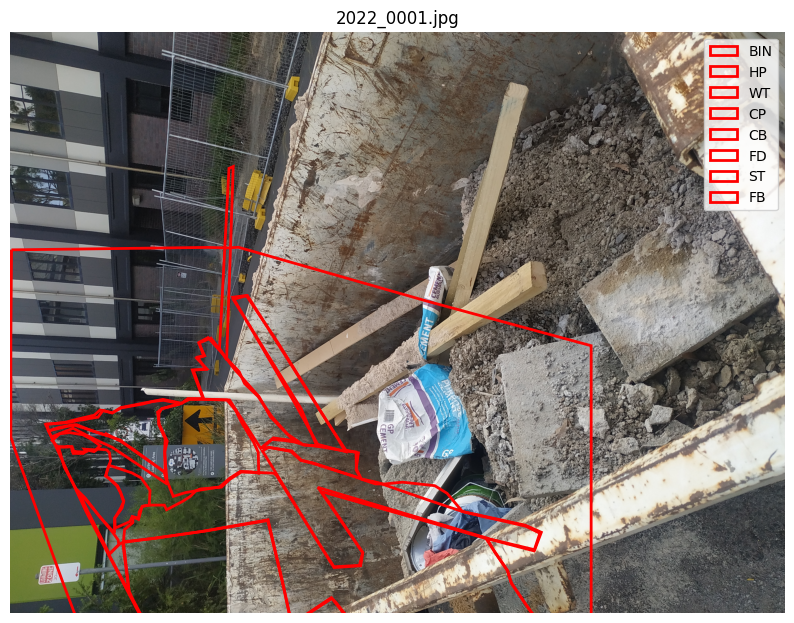

In [2]:
def visualize_image_with_annotations(image_path, annotation_path):
    img = Image.open(image_path)
    with open(annotation_path, 'r') as f:
        annotation = json.load(f)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()
    for shape in annotation['shapes']:
        label = shape['label']
        points = shape['points']
        polygon = Polygon(points, closed=True, fill=False, edgecolor='red', linewidth=2, label=label)
        ax.add_patch(polygon)
    plt.title(os.path.basename(image_path))
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.axis('off')
    plt.show()

visualize_image_with_annotations('Files/2022_0001.jpg', 'Files/2022_0001.json')


In [4]:
class_map = {'BIN': 1, 'HP': 2, 'WT': 3, 'CP': 4, 'CB': 5, 'FD': 6, 'ST': 7, 'FB': 8}

def create_mask_from_json(json_file, image_size):
    with open(json_file, 'r') as f:
        data = json.load(f)
    mask = Image.new("L", image_size, 0)
    draw = ImageDraw.Draw(mask)
    for shape in data['shapes']:
        label = shape['label']
        polygon = [tuple(p) for p in shape['points']]
        class_id = class_map.get(label, 0)
        draw.polygon(polygon, outline=class_id, fill=class_id)
    return mask

os.makedirs("Masks", exist_ok=True)
for fname in os.listdir("Files"):
    if fname.endswith(".json"):
        base = fname.replace(".json", "")
        img_path = f"Files/{base}.jpg"
        json_path = f"Files/{base}.json"
        mask = create_mask_from_json(json_path, Image.open(img_path).size)
        mask.save(f"Masks/{base}.png")


In [5]:
X, Y = [], []
target_size = (256, 256)
for img_file in sorted(os.listdir("Files")):
    if img_file.endswith(".jpg"):
        mask_file = img_file.replace(".jpg", ".png")
        img = Image.open(f"Files/{img_file}").resize(target_size)
        mask = Image.open(f"Masks/{mask_file}").resize(target_size, resample=Image.NEAREST)
        X.append(np.array(img) / 255.0)
        Y.append(np.array(mask))
X = np.array(X)
Y = np.array(Y)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [6]:
def build_unet_model(input_shape=(256, 256, 3), num_classes=9):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    u7 = layers.UpSampling2D()(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c7)
    model = models.Model(inputs, outputs)
    return model

model = build_unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 64, 64, 128)       │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 64, 64, 192)       │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 64)        │         110,656 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 128, 128, 64)      │               

 Total params: 438,937 (1.67 MB)

 Trainable params: 438,937 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=4
)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 717ms/step - accuracy: 0.3599 - loss: 1.8174 - val_accuracy: 0.4844 - val_loss: 1.6467
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 741ms/step - accuracy: 0.5097 - loss: 1.5393 - val_accuracy: 0.4845 - val_loss: 1.6092
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 761ms/step - accuracy: 0.5171 - loss: 1.4792 - val_accuracy: 0.4845 - val_loss: 1.6253
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 808ms/step - accuracy: 0.5173 - loss: 1.5073 - val_accuracy: 0.4845 - val_loss: 1.5866
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 738ms/step - accuracy: 0.5246 - loss: 1.4475 - val_accuracy: 0.4845 - val_loss: 1.5675
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 802ms/step - accuracy: 0.5142 - loss: 1.4383 - val_accuracy: 0.4966 - val_loss: 1.5759
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 728ms/step - accuracy: 0.5442 - loss: 1.3970 - val_accuracy: 0.4965 - val_loss: 1.5406
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 781ms/step - accuracy: 0.5105 - loss: 1.4558 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


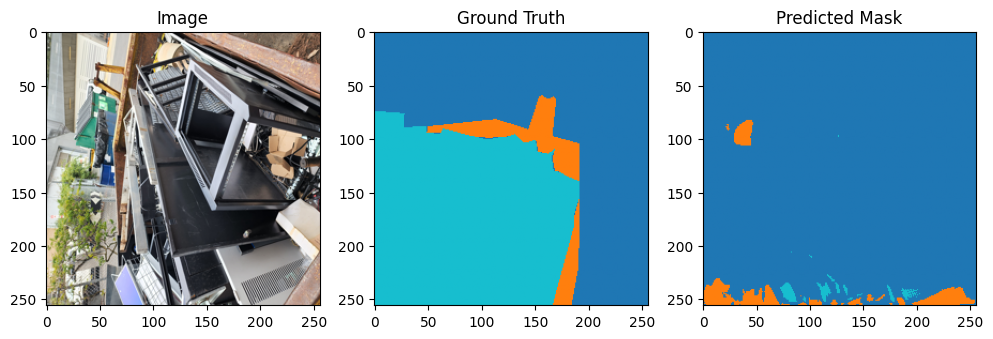

In [15]:
def visualize_prediction(model, image, true_mask):
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = np.argmax(pred_mask, axis=-1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='tab10')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='tab10')
    plt.title("Predicted Mask")
    plt.show()

visualize_prediction(model, X_val[0], Y_val[0])


In [21]:
val_loss, val_accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.5308 - loss: 1.4601
Validation Loss: 1.448242425918579, Validation Accuracy: 0.5367903709411621


In [22]:
model.save("CDW_Segmentation_UNet.h5")

In [23]:
import os
from matplotlib import pyplot as plt
import numpy as np

output_dir = "predicted_masks"
os.makedirs(output_dir, exist_ok=True)

for i in range(len(X_val)):
    pred_mask = model.predict(X_val[i:i+1])[0]
    pred_mask = np.argmax(pred_mask, axis=-1)
    plt.imsave(f"{output_dir}/mask_{i}.png", pred_mask, cmap='tab10')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [25]:
def mean_iou(y_true, y_pred):
    if y_pred.ndim == 3:
        y_pred = np.argmax(y_pred, axis=-1)
    
    y_true = y_true.astype(np.int32).flatten()
    y_pred = y_pred.astype(np.int32).flatten()
    
    iou = []
    for cls in np.unique(y_true):
        intersection = np.sum((y_true == cls) & (y_pred == cls))
        union = np.sum((y_true == cls) | (y_pred == cls))
        iou.append(intersection / union if union != 0 else 0)
    return np.mean(iou)

ious = []
for i in range(len(X_val)):
    pred = model.predict(X_val[i:i+1])[0]
    true = Y_val[i]
    ious.append(mean_iou(true, pred))

print("Mean IoU over validation set:", np.mean(ious))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save("CDW_Segmentation_UNet.keras")
np.save("validation_ious.npy", ious)
